In [3]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as pl
from matplotlib import rc
from matplotlib.pylab import rcParams
import matplotlib.ticker as mtick
from matplotlib.ticker import LogLocator
import seaborn as sb
import os
import pandas as pd

In [4]:
%matplotlib inline

In [5]:
# Let's setup graphics:
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text',usetex=False)
fontSize = 16
sb.set_style('dark')
rcParams['ytick.labelsize'] = fontSize
rcParams['xtick.labelsize'] = fontSize

In [12]:
# Prepare to manipulate data
bands2check = ['412','443','490','510','555','670']
rngDict = {'412':(4e-3,40),'443':(4e-3,40),'490':(4e-3,40),'510':(4e-3,40),
           '555':(4e-3,40),'670':(4e-3,40)}
figRows,figCols = 3,2
reshBands = np.reshape(bands2check,(figRows,figCols))
#rrsUncStd358Dict = dict.fromkeys(bands2check)
#rrsUncStd229Dict = dict.fromkeys(bands2check)
#rrsPercUncStd358Dict = dict.fromkeys(bands2check)
#rrsPercUncStd229Dict = dict.fromkeys(bands2check)
mainDir = '/accounts/ekarakoy/disk02/UNCERTAINTIES/Monte-Carlo/PACE_SNR/DATA/L2_L3/FullScale/GLOBALS/S2003193196'
idDir = 'ID_MinSNR'
specDir = os.path.join(mainDir,idDir)
dataDir = os.path.join(specDir,'L3bs/')
saveDir = os.path.join(specDir,'Distros/')
sue = 'SU19'
fn = 'S20031932003196.L3b_4D_%s.nc' % sue
fp = os.path.join(dataDir,fn)

In [9]:
idDir

'ID_MinSNR'

In [13]:
os.path.exists(fp)

True

In [11]:
fp

'~/disk02/UNCERTAINTIES/Monte-Carlo/PACE_SNR/DATA/L2_L3/FullScale/GLOBALS/S2003193196/ID_MinSNR/L3bs/S20031932003196.L3b_4D_SU19.nc'

In [14]:
ds = nc.Dataset(fp)

In [15]:
gv= ds.groups['level-3_binned_data'].variables

In [16]:
rrsDict = dict.fromkeys(bands2check)
rrsUncDict = dict.fromkeys(bands2check)
rrsPercUncDict = dict.fromkeys(bands2check)

In [17]:
binlist = gv['BinList'][:]
wts = binlist['weights']
for band in bands2check:
    lbl = 'Rrs_' + band
    ulbl = 'Rrs_unc_' + band
    rrsDict[band] = gv[lbl][:]['sum']
    rrsUncDict[band] = gv[ulbl][:]['sum']
    print("%s: %s - %d | %s - %d" %(band,lbl,rrsDict[band].shape[0],
                                    ulbl,rrsUncDict[band].shape[0]))

412: Rrs_412 - 1085107 | Rrs_unc_412 - 1085107
443: Rrs_443 - 1085107 | Rrs_unc_443 - 1085107
490: Rrs_490 - 1085107 | Rrs_unc_490 - 1085107
510: Rrs_510 - 1085107 | Rrs_unc_510 - 1085107
555: Rrs_555 - 1085107 | Rrs_unc_555 - 1085107
670: Rrs_670 - 1085107 | Rrs_unc_670 - 1085107


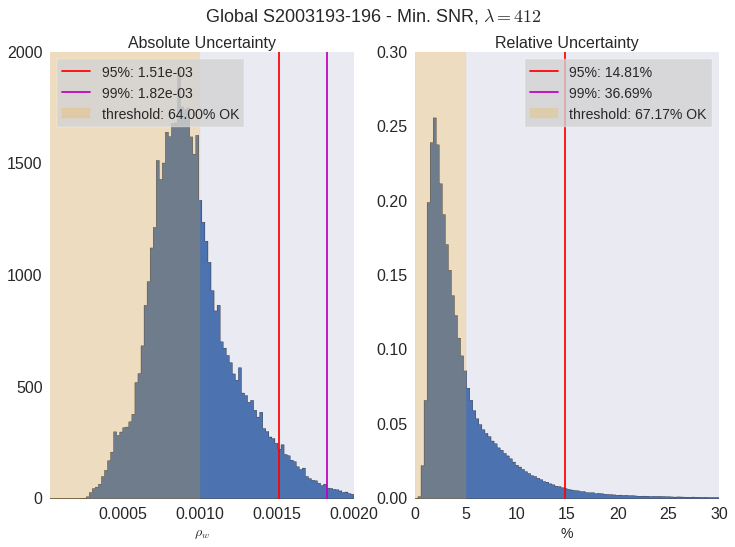

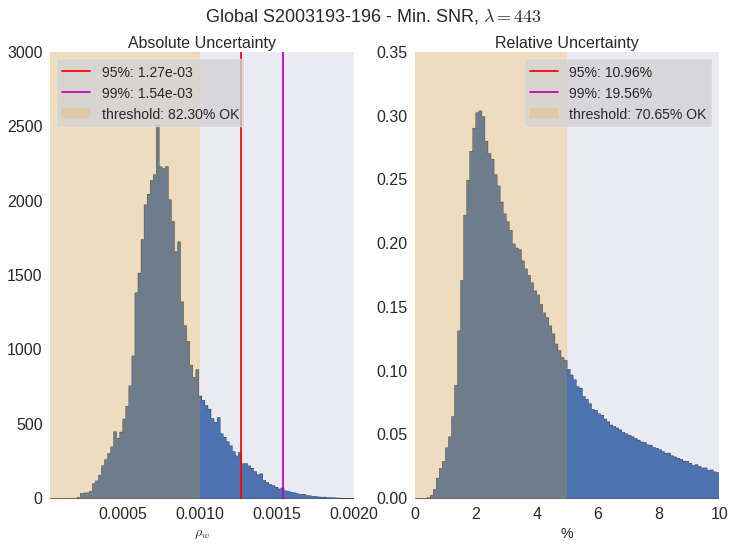

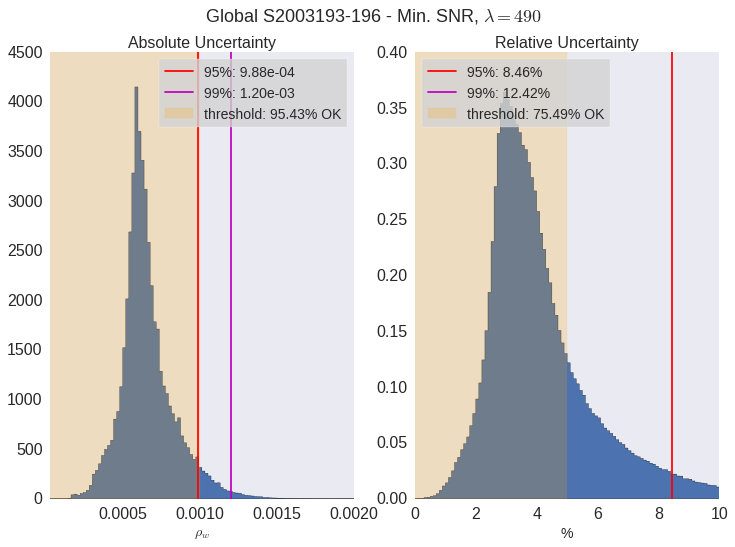

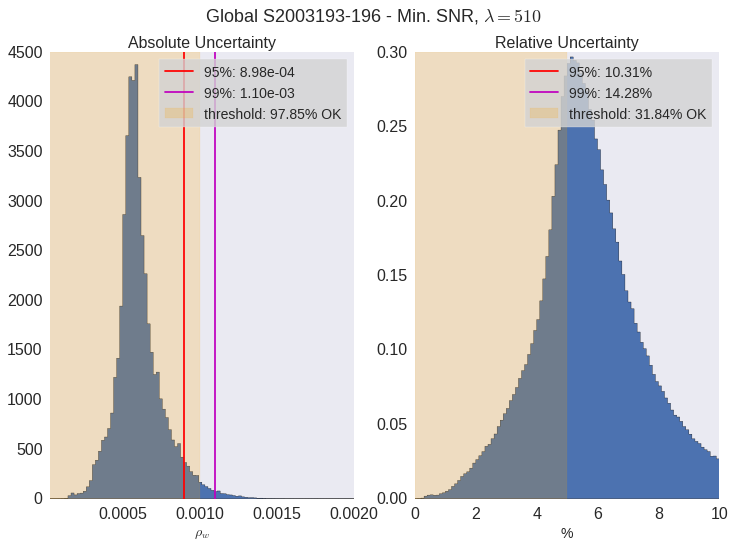

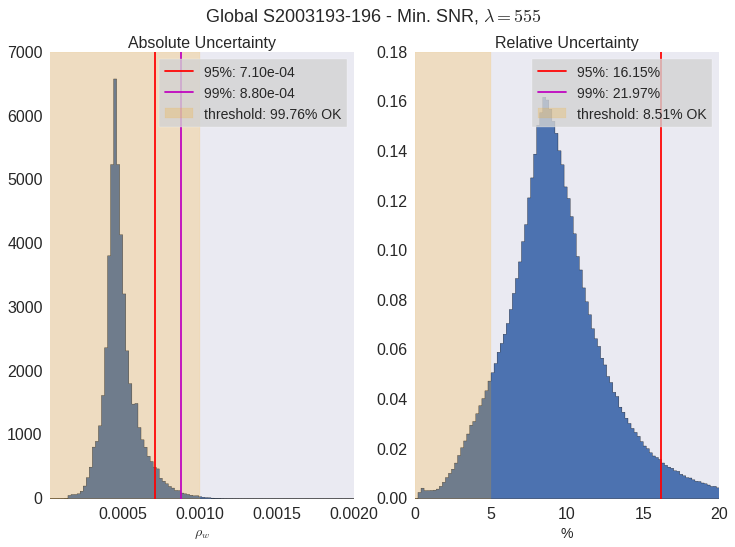

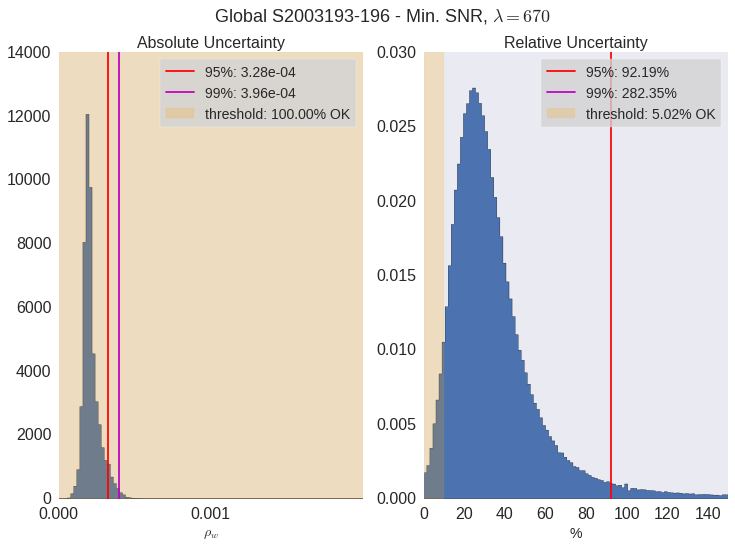

In [19]:
def GetDataAndPlotDistros(band,**kwds):
    """
    Creates rrs Uncertainty and percent uncertainty for given band.
    
    Inputs
    -------
    band: str or int. Must match bands addressed.
    
    keyword args:
        "saveFig" [(False) | True]: figure is saved to file
        "plotDists" [(False) | True]: distributions plotted for both uncertainty measurements
        "saveName [('NoName')]: file name to save fig under activated if saveFig==True. 
        
    Outputs (as ordered below)
    --------
    rrsP: array, percent uncertainty
    rrsWUnc: array, (weighted) absolute uncertainty
    rrsP95: float, 95th% value from sorted(rrsP)
    rrsWU95: float, 95th% value from sorted(rrsWU95)
    """
    saveFig = kwds.pop("saveFig",False)
    plotDists = kwds.pop("plotDists",False)
    band = str(band)
    rngDict={'412':(2.5e-5,0.002),'443':(2.5e-5,0.002),'490':(2.5e-5,0.002),
            '510':(2.5e-5,0.002),'555':(2.5e-5,0.002),'670':(0,0.002)}
    percRngDict={'412':(0,30),'443':(0,10),'490':(0,10),
                '510':(0,10),'555':(0,20),'670':(0,150)}
    rrsUncTreshDict = {'412':0.001,'443':0.001,'490':0.001,
                     '510':0.001,'555':0.001,'670':0.002}
    rrsPercThreshDict = {'412':5,'443':5,'490':5,
                     '510':5,'555':5,'670':10}
    rrsUnc=rrsUncDict[band]
    rrsWUnc = rrsUnc / wts * np.pi
    rrsP = rrsUnc / rrsDict[band] * 100
    rrsP=rrsP[rrsP != np.inf]
    rrsPtemp = np.sort(rrsP)
    rrsP95 = rrsPtemp[int(np.floor(rrsPtemp.size * .95))]
    rrsP99 = rrsPtemp[int(np.floor(rrsPtemp.size * .99))]
    rrsWUtemp = np.sort(rrsWUnc)
    rrsWU95 = rrsWUtemp[int(np.floor(rrsWUtemp.size * .95))]
    rrsWU99 = rrsWUtemp[int(np.floor(rrsWUtemp.size * .99))]
    if plotDists:
        rrsUncThr = rrsUncTreshDict[band]
        rrsPrUnThr = rrsPercThreshDict[band]
        rng = rngDict[band]
        pRng = percRngDict[band]

        f,ax = pl.subplots(ncols=2,figsize=(12,8))

        f.suptitle(r'Global S2003193-196 - Min. SNR, $\lambda=%s$' % band,fontsize=18)
        ax[0].hist(rrsWUnc,bins=100,range = (rng),histtype='stepfilled',
               normed=True);
        ax[0].set_xlabel(r'$\rho_w$',fontsize=14)
        percOK = rrsWUnc[rrsWUnc <= rrsUncThr ].size / rrsWUnc.size * 100
        ax[0].set_title('Absolute Uncertainty',fontsize=16)
        ax[0].axvspan(0,rrsUncThr,color='orange',alpha=0.2,label="%s: %.2f%% OK" %("threshold",percOK))
        ax[0].axvline(x=rrsWU95,color='red',label="%s %.2e" % ('95%:',rrsWU95))
        ax[0].axvline(x=rrsWU99,color='m',label="%s %.2e" % ('99%:',rrsWU99))
        ax[0].set_xlim(rng)
        leg = ax[0].legend(loc='best',frameon=True,fontsize=14,framealpha=0.8)
        leg.get_frame().set_facecolor('lightgray')
        if band =='670':
            xt = np.arange(0,rng[1],1e-3)
            ax[0].set_xticks(xt)
        ax[1].hist(rrsP,bins=100,range = (0,pRng[1]),histtype='stepfilled',
               normed=True);
        ax[1].set_xlabel('%',fontsize=14);
        percOK = rrsP[rrsP <= rrsPrUnThr].size / rrsP.size * 100
        ax[1].set_title('Relative Uncertainty',fontsize=16)
        ax[1].axvspan(0,rrsPrUnThr,color='orange',alpha=0.2,label="%s: %.2f%% OK" %("threshold",percOK))
        ax[1].axvline(x=rrsP95,color='red',label="%s %.2f%%" % ('95%:',rrsP95))
        ax[1].axvline(x=rrsP99,color='m',label="%s %.2f%%" %('99%:',rrsP99) )
        ax[1].set_xlim([0,pRng[1]])
        leg = ax[1].legend(loc='best',frameon=True,fontsize=14,framealpha=0.8)
        leg.get_frame().set_facecolor('lightgray')
    if saveFig:
        saveName = kwds.pop("saveName","noName")
        f.savefig(savename,format='png')
    return rrsP,rrsWUnc,rrsP95,rrsWU95,rrsP99,rrsWU99

band = bands2check[0]
rpdKeys = ['rho_' + b + '_perc' for b in bands2check]
rwudKeys = ['rho_'+ b + '_abs' for b in bands2check]
minSNRDict = dict.fromkeys(rpdKeys+ rwudKeys)
for band in bands2check:
    savename = saveDir + idDir + band
    rp,rwu,rp95,rwu95,rp99,rwu99 = GetDataAndPlotDistros(band,plotDists=True,saveFig=True,saveName=savename)
    rpky,ruky='rho_'+band+'_perc','rho_'+band+'_abs'
    minSNRDict[rpky] = {'mean':rp.mean(),'median':np.median(rp),'95th%ile':rp95,'99th%ile':rp99}
    minSNRDict[ruky] = {'mean':rwu.mean(),'median':np.median(rwu),'95th%ile':rwu95,'99th%ile':rwu99}

In [20]:
import pickle
tableDict= pickle.load(open('/accounts/ekarakoy/UNCERTAINTIES/datafiles/TableDict.p','rb'))
tableDict['MIN_SNR'] = minSNRDict
pickle.dump(tableDict,open('/accounts/ekarakoy/UNCERTAINTIES/datafiles/TableDict2.p','wb'))

In [21]:
tableDict

{'ID1': {'rho_412_abs': {'95th%ile': 0.00076655153,
   '99th%ile': 0.00098017859,
   'mean': 0.00046881035,
   'median': 0.0004398234},
  'rho_412_perc': {'95th%ile': 7.27882,
   '99th%ile': 17.81624,
   'mean': 2.9741096,
   'median': 1.6864104},
  'rho_443_abs': {'95th%ile': 0.00064507668,
   '99th%ile': 0.00082309626,
   'mean': 0.00039720151,
   'median': 0.00037071516},
  'rho_443_perc': {'95th%ile': 5.4472666,
   '99th%ile': 9.6186619,
   'mean': 2.2613051,
   'median': 1.6972591},
  'rho_490_abs': {'95th%ile': 0.00050265866,
   '99th%ile': 0.00063774455,
   'mean': 0.00032412171,
   'median': 0.0003046793},
  'rho_490_perc': {'95th%ile': 4.2607512,
   '99th%ile': 6.2355623,
   'mean': 2.1284204,
   'median': 1.823251},
  'rho_510_abs': {'95th%ile': 0.00045553513,
   '99th%ile': 0.00057805452,
   'mean': 0.00029925368,
   'median': 0.00028274112},
  'rho_510_perc': {'95th%ile': 5.2064009,
   '99th%ile': 7.2437315,
   'mean': 3.0344744,
   'median': 2.7627547},
  'rho_555_abs': {'